## Feature engineering and modeling

In [1]:
# Import of relevant packages
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay, accuracy_score, recall_score,f1_score
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn.model_selection import GridSearchCV,cross_val_score,RandomizedSearchCV,  train_test_split, cross_val_predict

RSEED = 45


In [2]:
df = pd.read_csv('datasets/kickstarter/kickstarter_cleaned.csv')
df1 = df.copy()
#df1
#df.head()

In [3]:
y = df1["outcome"].astype(str)
X = df1 .loc[:, df1. columns != "outcome"].astype(str)
#print('Input', X.shape)
#print('Output', y.shape)

## Splitting data for testing

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

## Predictive Modelling using Pipelines and Grid Search

In [5]:
# can be removed if model is saved 

cat_attribs = ['category', 'subcategory', 'country']
num_attribs = ['yr_launched', 'duration_days', 'goal']

# Define pipelines for numerical and categorical attributes
num_pipeline = Pipeline([
   ('scaler', StandardScaler())
    ])

cat_pipeline = Pipeline([
   ('encoder', OneHotEncoder(handle_unknown="ignore"))
])

# Define preprocessing ColumnTransformer
preprocessing = ColumnTransformer([
   ("num", num_pipeline, num_attribs),
   ("cat", cat_pipeline, cat_attribs),
 ])

# Optimized parameters

optimized_params = {
    'n_estimators': 800,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'max_depth': None, 
    'bootstrap': True,
    'random_state': 42
}

# Define the estimator with optimized parameters
estimator = RandomForestClassifier(**optimized_params)

# Create the pipeline
# Create the pipeline
grid_rf = Pipeline([
    ('preprocessing', preprocessing),
    ('rf', estimator)
])

In [6]:
# Fit the model
grid_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['yr_launched',
                                                   'duration_days', 'goal']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['category', 'subcategory',
                                                   'country'])])),
                ('rf',
                 RandomForestClassifier(min_samples_leaf=4,
                                        min_samples_split=10, n_estimators=800,
                                        random_state=42))])

In [6]:
import joblib

# save the model
joblib.dump(grid_rf, "models/grid_rf.joblib")

# load the model
loaded_rf = joblib.load("models/grid_rf.joblib")

In [7]:
# Now you can use the loaded model to make predictions
y_pred_train = loaded_rf.predict(X_train)
print('Training dataset results')
print(classification_report(y_pred_train, y_train))

Training dataset results
              precision    recall  f1-score   support

           0       0.85      0.74      0.79    181521
           1       0.56      0.72      0.63     83648

    accuracy                           0.73    265169
   macro avg       0.71      0.73      0.71    265169
weighted avg       0.76      0.73      0.74    265169



In [8]:
y_pred = loaded_rf.predict(X_test)
print('Testing dataset results')
print(classification_report(y_pred, y_test))

# Retrieve OOB score and error#######focus
#oob_score = loaded_rf.oob_score_
#oob_error = 1 - oob_score

Testing dataset results
              precision    recall  f1-score   support

           0       0.82      0.71      0.76     45466
           1       0.50      0.65      0.57     20827

    accuracy                           0.69     66293
   macro avg       0.66      0.68      0.66     66293
weighted avg       0.72      0.69      0.70     66293



In [ ]:
### Optimizing via Grid Search

In [9]:
from sklearn.inspection import permutation_importance
result = permutation_importance(loaded_rf, X, y, n_repeats=10, random_state=RSEED, n_jobs=-1)

# Create a Series with the importances
feat_importances = pd.Series(result.importances_mean, index=X.columns)

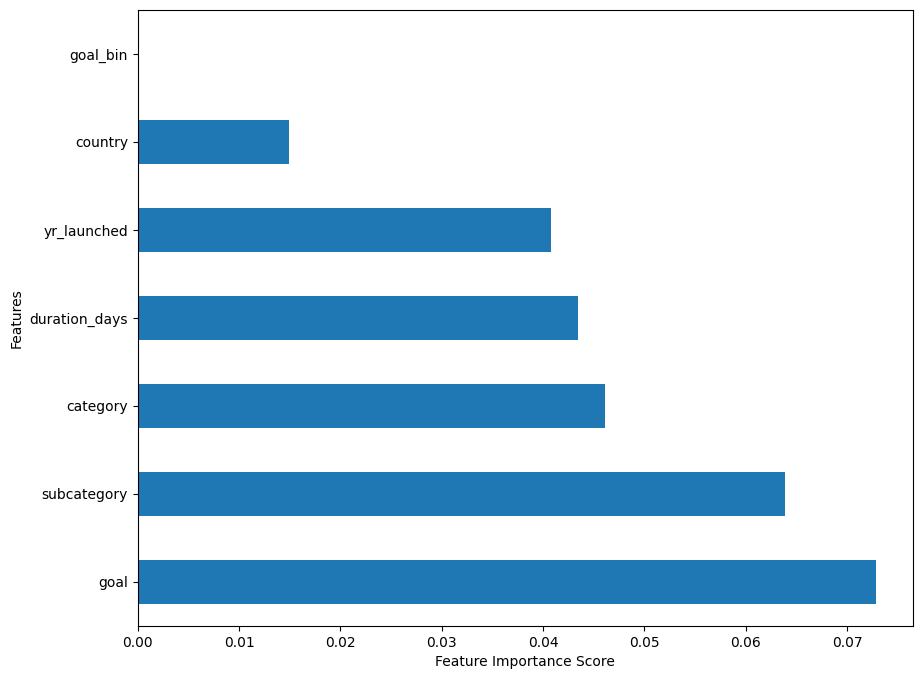

In [15]:
# Get the 20 most important features
top_feat_importances = feat_importances.nlargest(20)

# Plot the feature importances
plt.figure(figsize=(10, 8))
top_feat_importances.plot(kind='barh')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')

# Display the plots
plt.show()

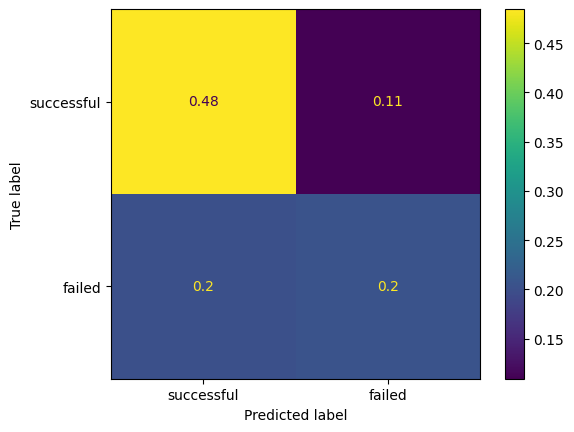

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['successful','failed'])
cmd.plot()